<a href="https://colab.research.google.com/github/37stu37/FFE/blob/master/sampling_PGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%time 
%%capture
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes

CPU times: user 691 ms, sys: 93.6 ms, total: 785 ms
Wall time: 1min 32s


In [2]:
# Load the Drive helper and mount
from google.colab import drive
%tensorflow_version 2.x
# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import glob
from math import sqrt
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd
import geopandas as gpd
import math

%matplotlib inline

In [4]:
path = '/content/drive/My Drive/05_Sync/FFE/FireNetwork/00_input'
!ls '/content/drive/My Drive/05_Sync/FFE/FireNetwork/00_input'

buildings_raw.cpg		   outputs_centroids_allpga_1000GMFsPERCENTILES
buildings_raw.dbf		   SA2.cpg
buildings_raw.prj		   SA2.dbf
buildings_raw_pts.cpg		   SA2.prj
buildings_raw_pts.dbf		   SA2.qpj
buildings_raw_pts.mshp		   SA2.shp
buildings_raw_pts.prj		   SA2.shx
buildings_raw_pts.shp		   source_target.csv
buildings_raw_pts.shx		   WairarapNich.cpg
buildings_raw.qpj		   WairarapNich.dbf
buildings_raw.shp		   WairarapNich.prj
buildings_raw.shx		   WairarapNich.qpj
GD_wind.csv			   WairarapNich.shp
HikWgtmax.dbf			   WairarapNich.shx
HikWgtmax.prj			   Wairau.dbf
HikWgtmax.qpj			   Wairau.prj
HikWgtmax.shp			   Wairau.qpj
HikWgtmax.shx			   Wairau.shp
HikWgtmin.dbf			   Wairau.shx
HikWgtmin.prj			   WellWHV.dbf
HikWgtmin.qpj			   WellWHV.prj
HikWgtmin.shp			   WellWHV.qpj
HikWgtmin.shx			   WellWHV.shp
outputs_centroids_allpga_1000GMFs  WellWHV.shx


In [0]:
# SA2 input data
SA2 = gpd.read_file(os.path.join(path, "SA2.shp"))
# PGA input data
PGA = gpd.read_file(os.path.join(path, "WellWHV.shp"))
# buildings data
buildings = gpd.read_file(os.path.join(path, "buildings_raw.shp"))

In [30]:
SA2.columns, PGA.columns, buildings.columns

(Index(['OBJECTID', 'SA22018_V1', 'SA22018__1', 'LAND_AREA_', 'AREA_SQ_KM',
        'Pop_Total_', 'SA2_ID', 'Shape_Leng', 'Shape_Area', 'PopDensity',
        'BldgFloor_', 'BldgFloo_1', 'NumberBldg', 'geometry'],
       dtype='object'),
 Index(['SA2', 'sid', 'lon', 'lat', 'mean', 'pone', 'ptwo', 'pthree', 'pfour',
        'pfive', 'psix', 'pseven', 'geometry'],
       dtype='object'),
 Index(['TARGET_FID', 'suburb_loc', 'Combustibl', 'SHAPE_Leng', 'SHAPE_Area',
        'AU2013Num', 'IgnProb_bl', 'RandProb', 'geometry'],
       dtype='object'))

In [0]:
buildings.suburb_loc

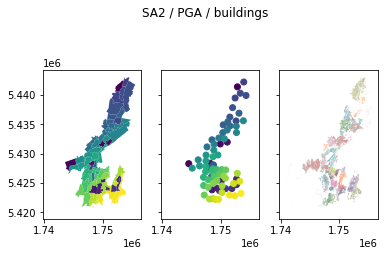

In [36]:
#plot
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharex=True, sharey=True)
fig.suptitle('SA2 / PGA / buildings')
SA2.plot(ax=ax1, column='SA2_ID')
PGA.plot(ax=ax2, column='SA2')
buildings.plot(ax=ax3, column='suburb_loc')

In [0]:
def merge(data1, data2):
  return data1.merge(data2, how='left', left_on='SA2_ID', right_on='SA2')\

def IgnitionProbability_SA2():
  data = merge(SA2, PGA)
  data['SA_IgnPrb'] = 1/(math.exp(-1*(-6.755+8.)))